This script plots all the flood locations by day.

In [33]:
from db_scripts.get_server_data import data_dir, fig_dir, get_db_table_as_df
from db_scripts.focus_intersection import subset_locations
import pandas as pd
import matplotlib.pyplot as plt
import math
from mpl_toolkits.basemap import Basemap
import numpy as np
import time
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
gis_data_dir = "C:/Users/Jeff/Google Drive/research/Sadler_3rdPaper_GIS_data/wgs/"

In [58]:
flood_df = pd.read_csv('{}norfolk_flooded_roads_data/STORM_data_flooded_streets_2010-2016_no_duplicates_clean_lat_lon.csv'.format(data_dir))
# flood_df = flood_df[flood_df['location'].isin(subset_locations)]

In [59]:
flood_df.columns

Index([u'field_1', u'﻿recid', u'location', u'event', u'eventType', u'xcoord',
       u'ycoord', u'dt', u'_date', u'_time', u'lon', u'lat'],
      dtype='object')

In [60]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in xrange(0, len(seq), size))

In [61]:
def get_num_rows(num_plots, ncols):
    return int(math.ceil(len(num_plots)/float(ncols)))

I noticed that a lot of the days are grouped together. For example 2015-09-23 to 2015-10-05 there are 11/13 days that are flooded. There are other similar instances where more than one day in a row are flooded. So I got to thinking to myself, maybe the "date" field isn't the best to look at but maybe we should be looking at the "event" column instead.

In [62]:
len(flood_df['event'].unique())

47

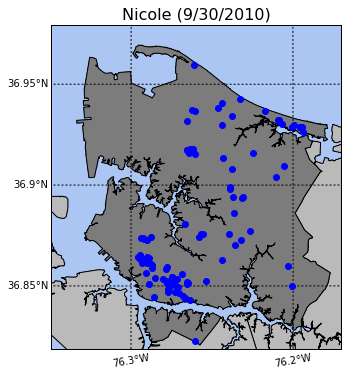

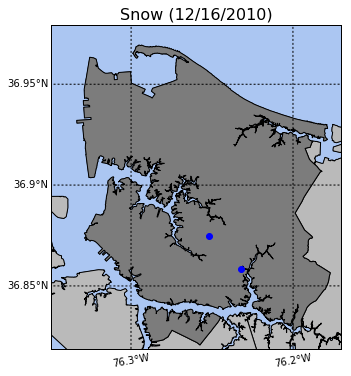

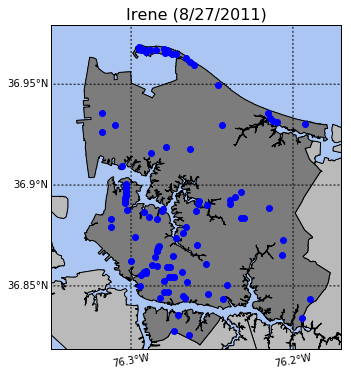

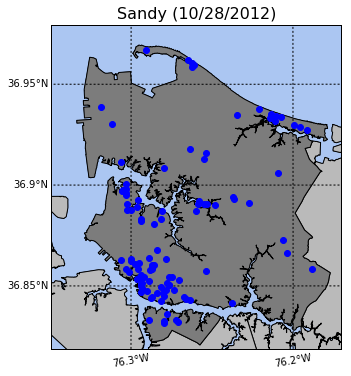

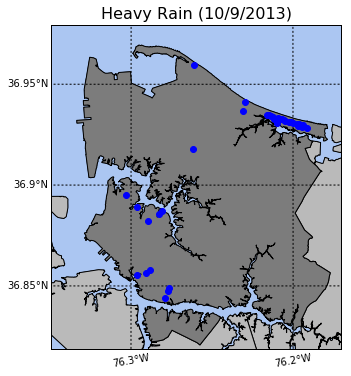

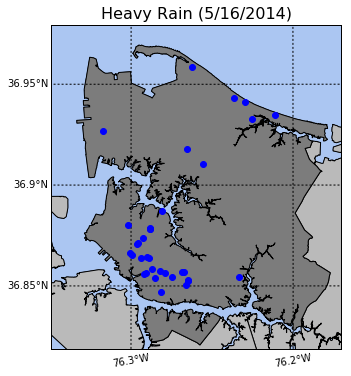

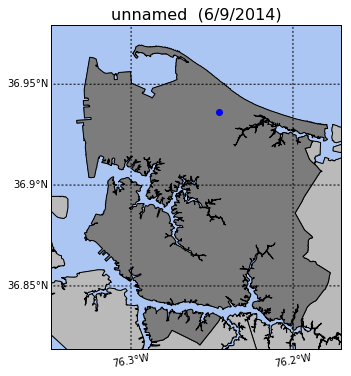

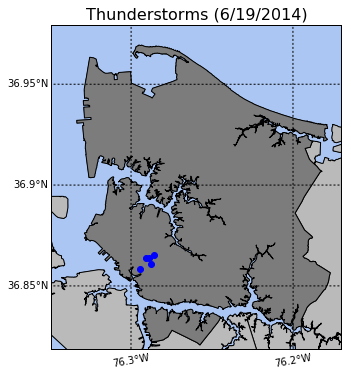

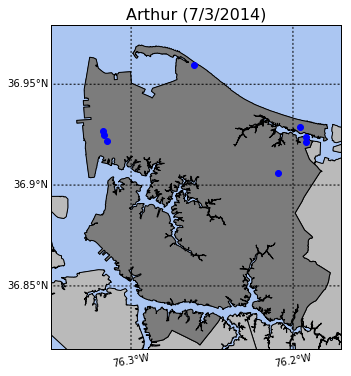

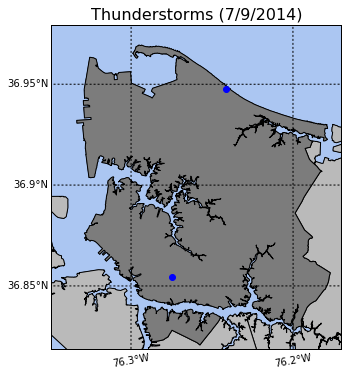

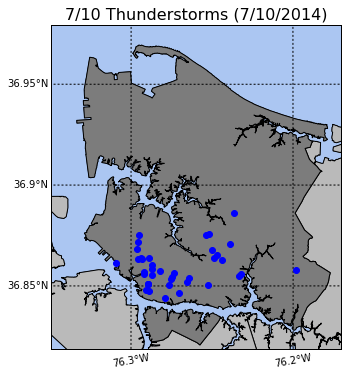

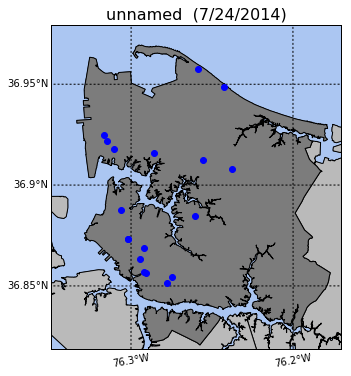

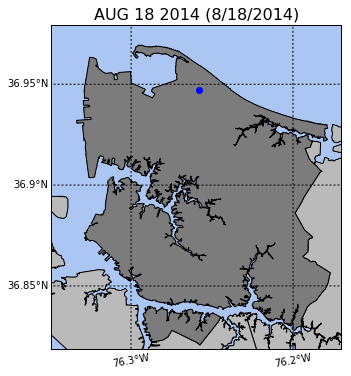

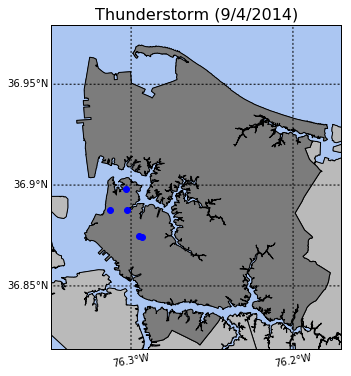

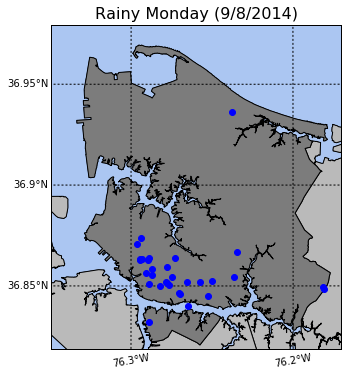

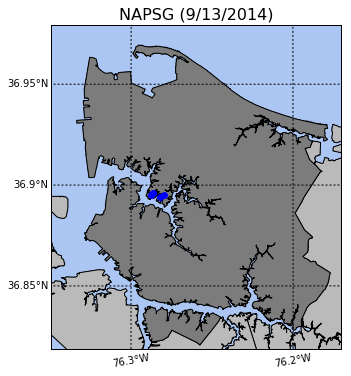

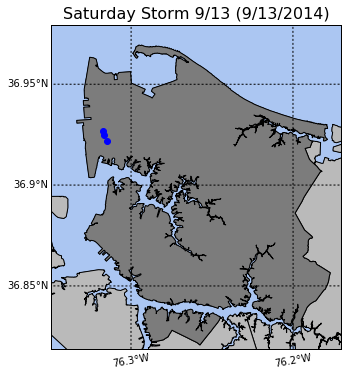

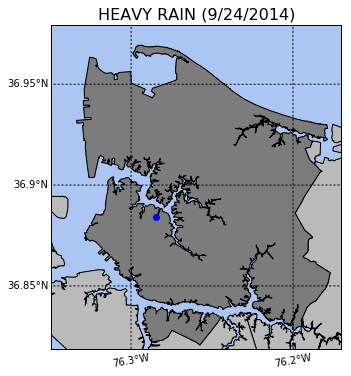

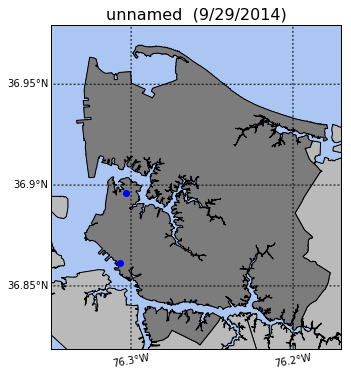

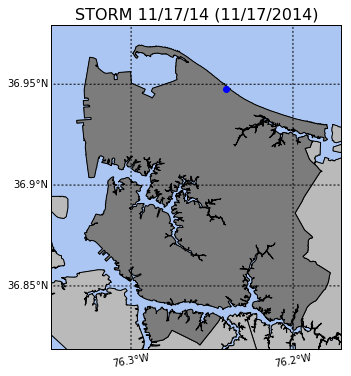

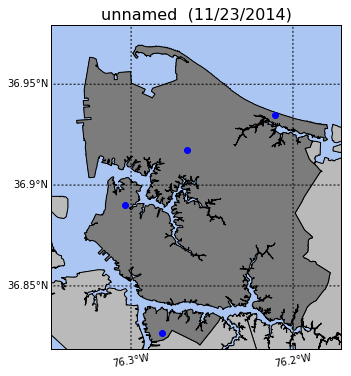

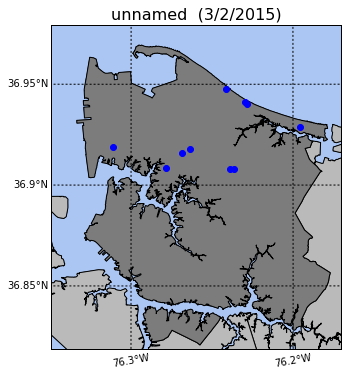

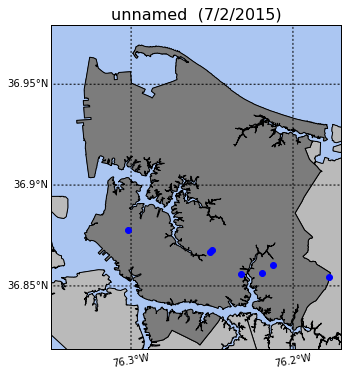

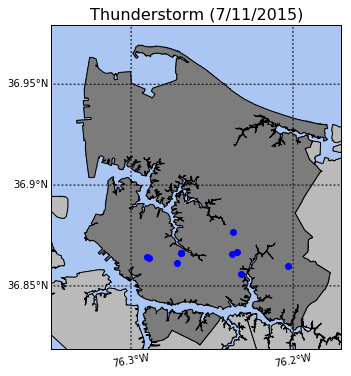

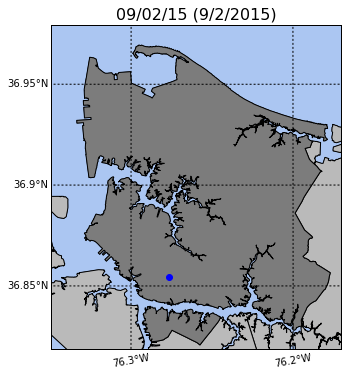

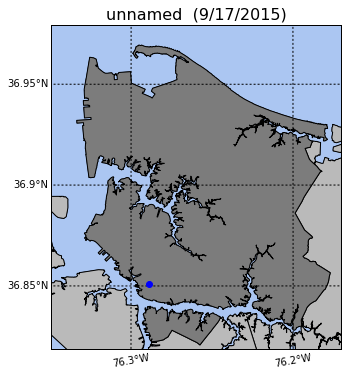

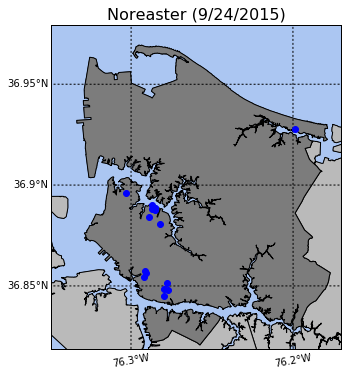

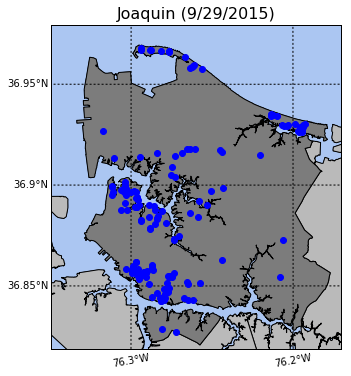

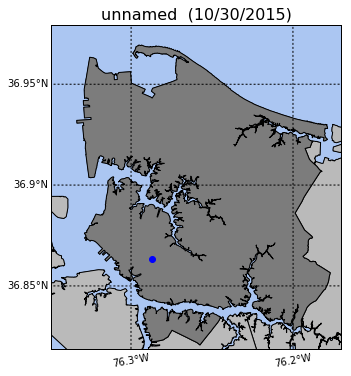

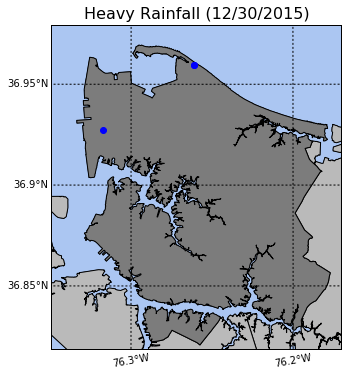

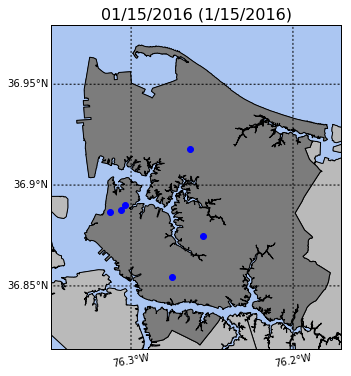

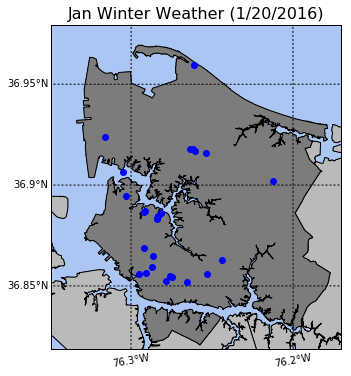

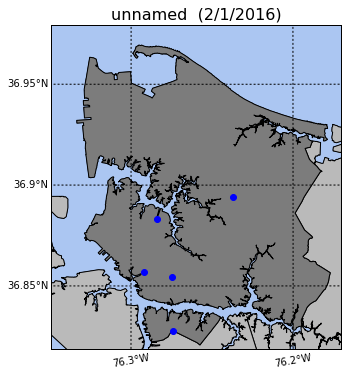

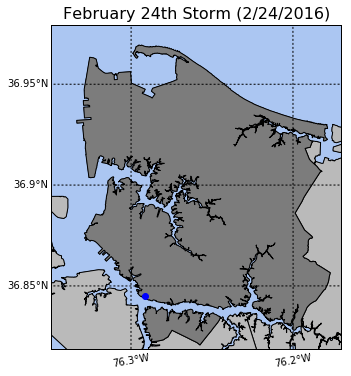

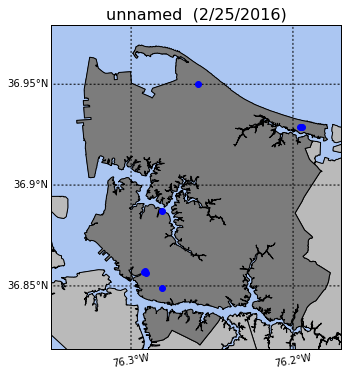

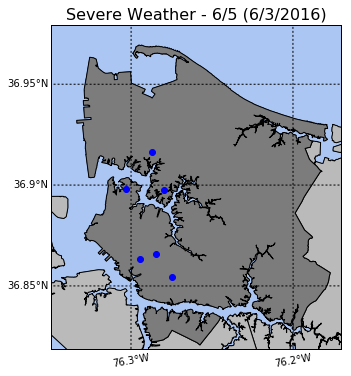

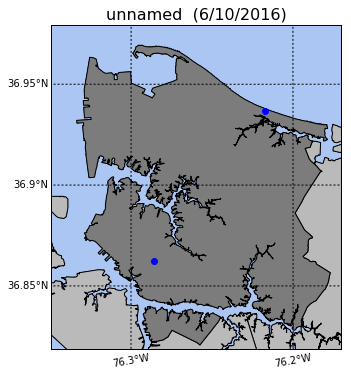

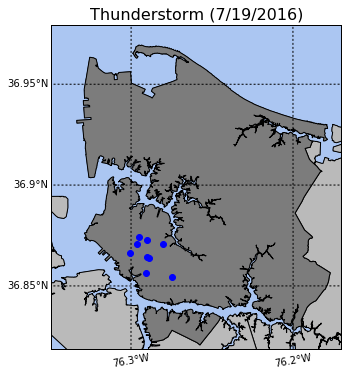

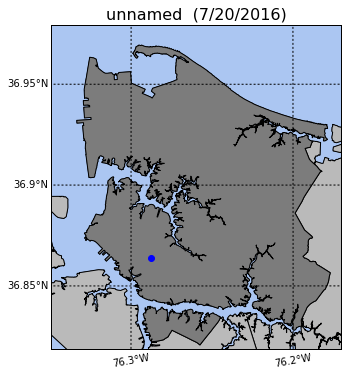

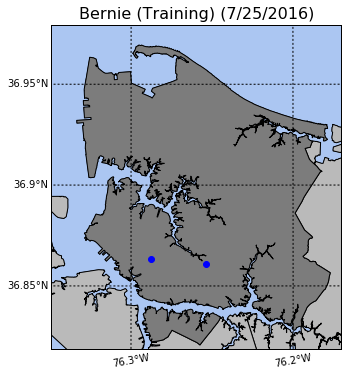

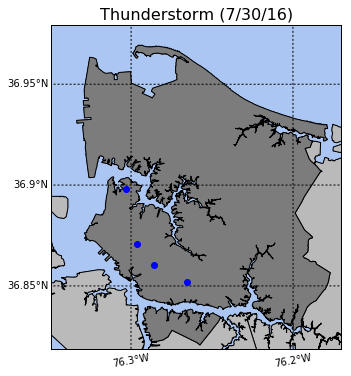

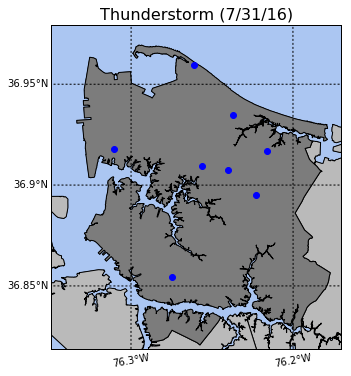

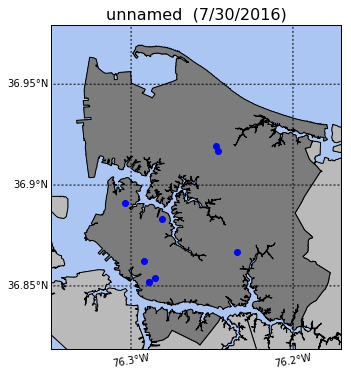

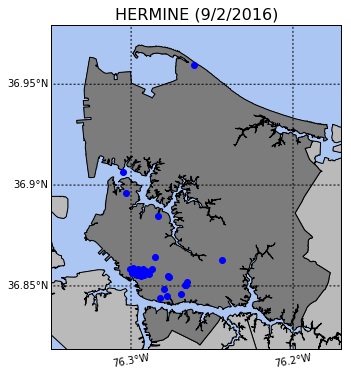

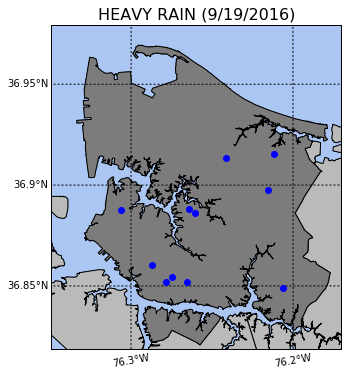

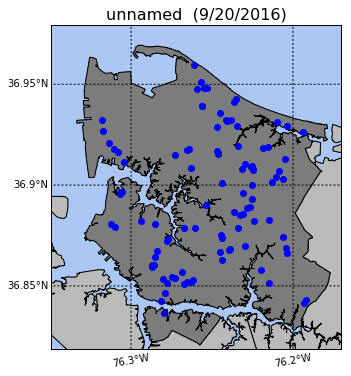

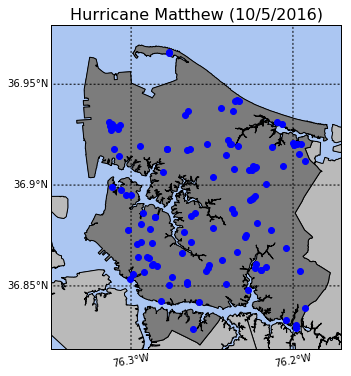

In [64]:
ncols = 1
for date_group in chunker(flood_df['event'].unique(), 1):
    nrows = get_num_rows(date_group, ncols)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5,5))
    ax_list = [axs]#.ravel()
    for i in range(len(date_group)):
        plot_df = flood_df[flood_df['event'] == date_group[i]]
        ax = ax_list[i]
        lats = flood_df['lat']
        lons = flood_df['lon']
        m = Basemap(resolution='c', projection='tmerc', lat_0 = lats.mean(), lon_0 = lons.mean(), ax=ax,
                    llcrnrlon=lons.min()*1.0004,llcrnrlat=lats.min()*0.9999,
                    urcrnrlon=lons.max()*0.9999,urcrnrlat=lats.max()*1.0003)
        
        m.drawmapboundary(fill_color='#abc6f2')
        m.readshapefile('{}nor_and_surr_counties_clip'.format(gis_data_dir), 'surr')    
        m.readshapefile('{}norfolk_boundary_wgs'.format(gis_data_dir), 'norfolk')
    
        # fill the shapefile pygns
        surr_patches   = []
        for shape in m.surr:
                surr_patches.append(Polygon(np.array(shape), True))
        ax.add_collection(PatchCollection(surr_patches, facecolor= '#bababa', edgecolor='k', linewidths=1., 
                                          zorder=2))

        nor_patches   = []
        for shape in m.norfolk:
                nor_patches.append(Polygon(np.array(shape), True))
        ax.add_collection(PatchCollection(nor_patches, facecolor= '#7c7c7c', edgecolor='k', linewidths=1., 
                                          zorder=2))

    
        latlabels = [1, 0, 0, 1] if i in [0, 4, 8, 12, 16] else [0, 0, 0, 0]
        lonlabels = [1, 0, 0, 1] if i > len(ax_list)-5 else [0, 0, 0, 0]
        m.drawparallels(np.arange(34,38,0.05), labels=latlabels)
        meridians = m.drawmeridians(np.arange(-77, -75, 0.1), labels=lonlabels)
        for mer in meridians:
            try:
                meridians[mer][1][0].set_rotation(10)
            except:
                pass

        x,y = m(plot_df['lon'].tolist(), plot_df['lat'].tolist())
        m.plot(x, y, 'bo', markersize=6)
        ax.set_title(date_group[i], fontsize=16)
    for ax in ax_list:
        if not ax.has_data():
            fig.delaxes(ax)
    fig.tight_layout(pad=0)
    fig.subplots_adjust(left=0.08, bottom=0.05)
    f_name = date_group[i].replace("/","_")
    f_name = f_name.replace(" ", "_")
    f_name = f_name.replace("(", "_")
    f_name = f_name.replace(")", "_")
    plt.savefig('{}plot_by_date_{}.png'.format(fig_dir, date_group[i].replace("/","_")), dpi=300)
    plt.show()